In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Define paths for train and test folders
train_path = "/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set/"
test_path = "/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/"

# List the contents of the Train and Test directories
print("Train Classes:", os.listdir(train_path))
print("Test Classes:", os.listdir(test_path))

Train Classes: ['FU-nail-fungus', 'FU-ringworm', 'VI-shingles', 'BA-impetigo', 'FU-athlete-foot', 'VI-chickenpox', 'PA-cutaneous-larva-migrans', 'BA- cellulitis']
Test Classes: ['FU-nail-fungus', 'FU-ringworm', 'VI-shingles', 'BA-impetigo', 'FU-athlete-foot', 'VI-chickenpox', 'PA-cutaneous-larva-migrans', 'BA- cellulitis']


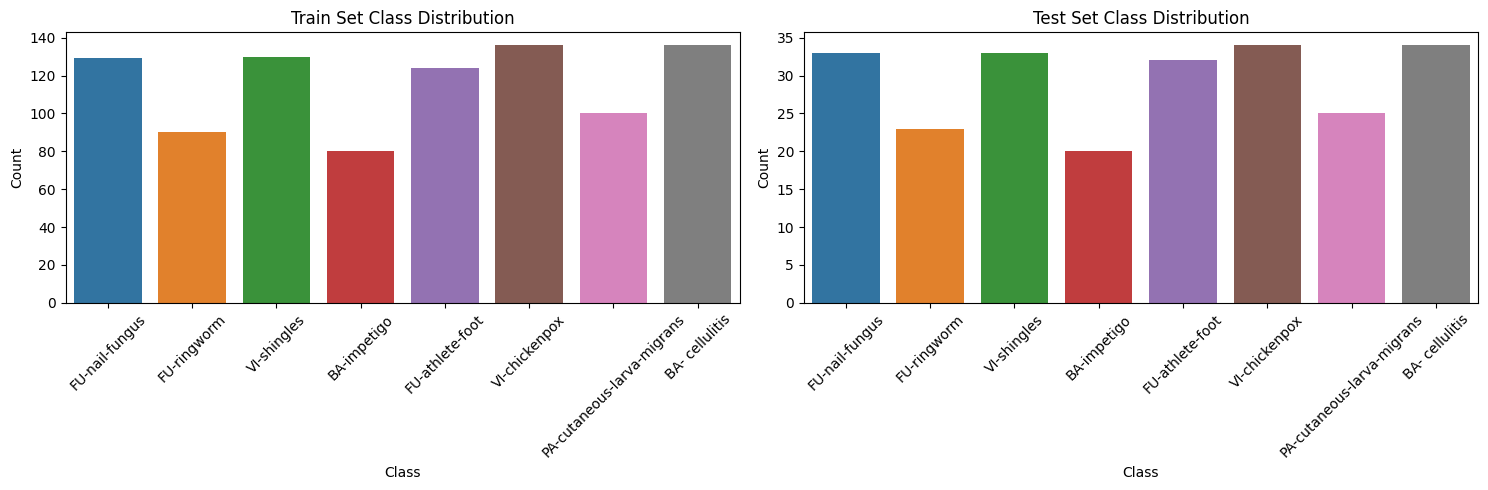

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to count images in each class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_class_counts = count_images(train_path)
test_class_counts = count_images(test_path)

# Convert to DataFrames for easier plotting
train_df = pd.DataFrame(list(train_class_counts.items()), columns=['Class', 'Count'])
test_df = pd.DataFrame(list(test_class_counts.items()), columns=['Class', 'Count'])

# Plot Train and Test class distributions
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='Class', y='Count', data=train_df, ax=ax[0])
ax[0].set_title("Train Set Class Distribution")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

sns.barplot(x='Class', y='Count', data=test_df, ax=ax[1])
ax[1].set_title("Test Set Class Distribution")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

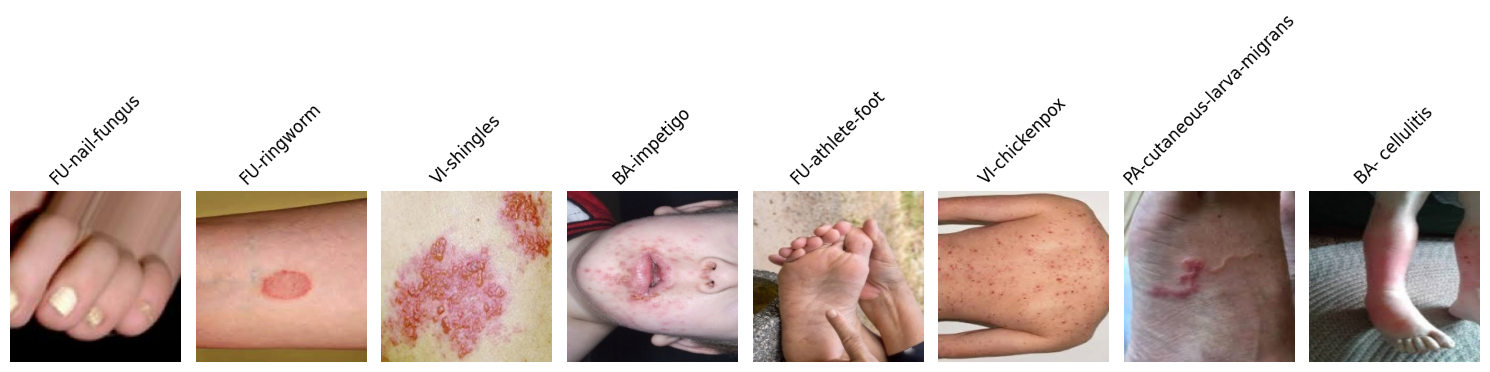

In [3]:
import random
from PIL import Image

def show_sample_images(directory, num_classes=8):
    classes = os.listdir(directory)
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 20))

    # Flatten axes array to make indexing easier
    axes = axes.flatten()

    for i, class_name in enumerate(classes[:num_classes]):
        class_path = os.path.join(directory, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name, rotation=45)  
        axes[i].axis('off')

    plt.tight_layout()  
    plt.show()

# Show sample images from Train set
show_sample_images(train_path)

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

Found 788 images belonging to 8 classes.
Found 136 images belonging to 8 classes.
Found 233 images belonging to 8 classes.


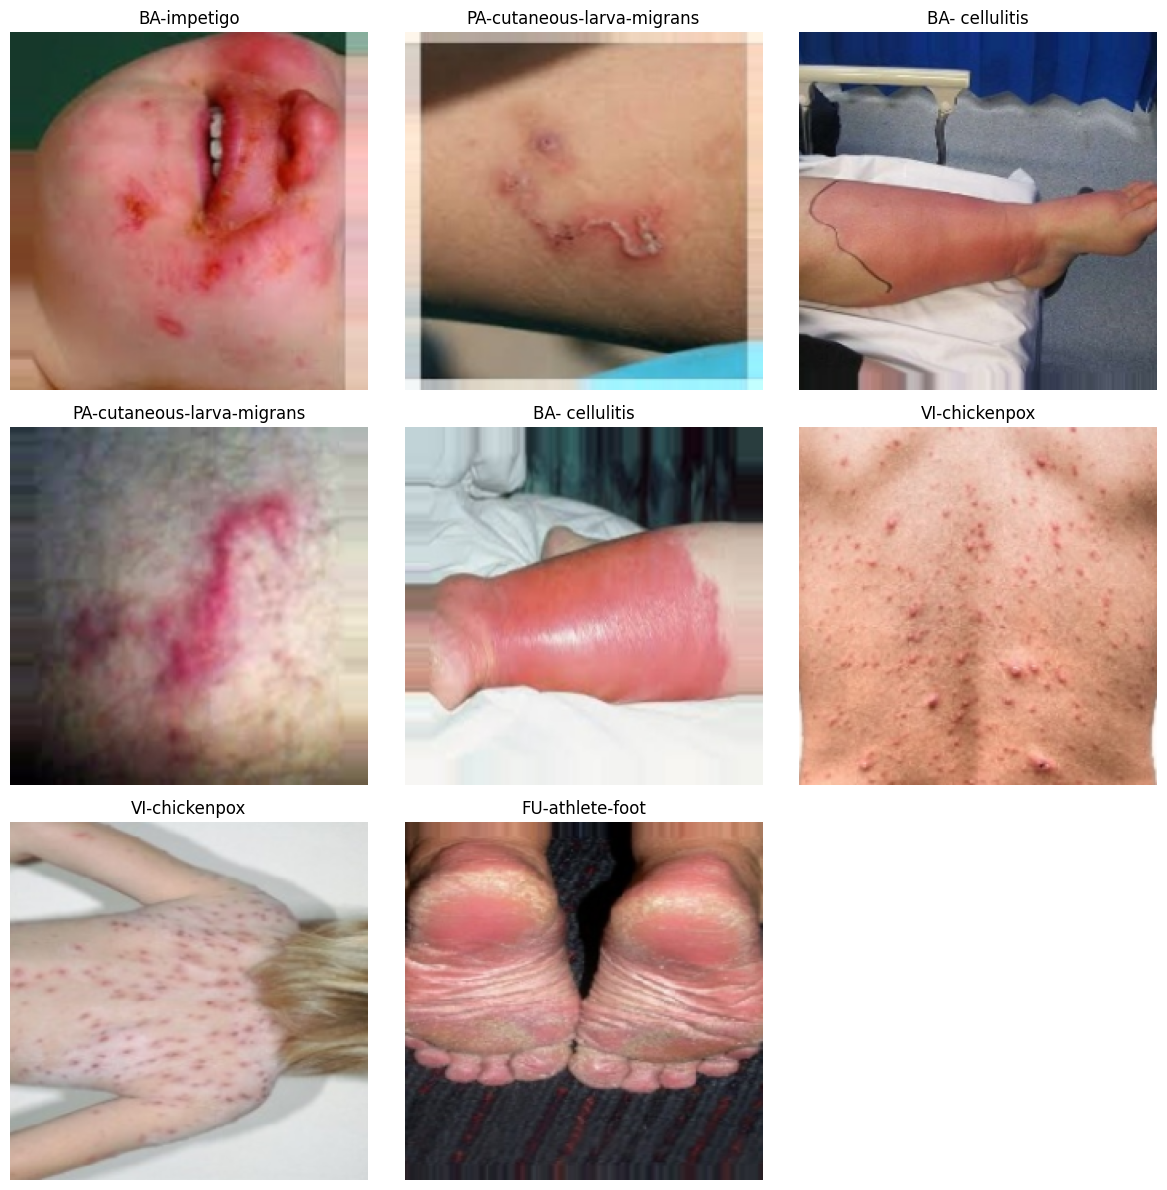

In [5]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    shear_range=0.2,         # Random shear
    zoom_range=0.2,          # Random zoom
    #horizontal_flip=True,    # Flip images horizontally
    validation_split=0.15    # Split validation set
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Just normalize for test data

# Load the Train and Validation datasets
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),  # Resize images for AlexNet and SqueezeNet input size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Load the Test dataset
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Get a batch of images and labels from the train_generator
augmented_images, labels = next(train_generator)

# Plot some of the images
def plot_augmented_images(images, labels, class_names, n=8):
    plt.figure(figsize=(12, 12))
    for i in range(n):
        plt.subplot(3, 3, i+1)
        img = images[i]
        label = labels[i]
        
        # Display the image
        plt.imshow(img)
        plt.title(class_names[np.argmax(label)])  # Get class name from one-hot encoded label
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Getting class names from the generator
class_names = list(train_generator.class_indices.keys())

# Show the augmented images
plot_augmented_images(augmented_images, labels, class_names)

In [6]:
def create_alexnet_model():
    model = models.Sequential()

    # 1st Convolutional Layer
    model.add(layers.Conv2D(96, (11, 11), strides=4, input_shape=(224, 224, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=2))

    # 2nd Convolutional Layer
    model.add(layers.Conv2D(256, (5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=2))

    # 3rd, 4th, 5th Convolutional Layers
    model.add(layers.Conv2D(384, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(384, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=2))

    # Flatten Layer
    model.add(layers.Flatten())

    # 1st Fully Connected Layer
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # 2nd Fully Connected Layer
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output Layer (8 classes for 8 skin infections)
    model.add(layers.Dense(8, activation='softmax'))

    return model


In [7]:
alexnet_model = create_alexnet_model()
alexnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_alexnet = alexnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs= 50 
)


Epoch 1/50


I0000 00:00:1729426021.170834     124 service.cc:145] XLA service 0x78646c008230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729426021.170885     124 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729426021.170889     124 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.0625 - loss: 2.0872 

I0000 00:00:1729426029.155314     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 715ms/step - accuracy: 0.1094 - loss: 2.0727 - val_accuracy: 0.1406 - val_loss: 2.0503
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.2500 - loss: 2.0600 - val_accuracy: 0.2500 - val_loss: 2.0824
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step - accuracy: 0.1559 - loss: 2.0484 - val_accuracy: 0.1484 - val_loss: 2.0456
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1250 - loss: 2.0035 - val_accuracy: 0.1250 - val_loss: 1.9865
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - accuracy: 0.1656 - loss: 2.0194 - val_accuracy: 0.2422 - val_loss: 1.9370
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 1.7997 - val_accuracy: 0.5000 - val_loss: 1.9195
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - accuracy: 0.2582 - loss: 1.9036 - val_accuracy: 0.2891 - val_loss: 1.7915
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2188 - loss: 2.1124 - val_accuracy: 0.3750 - val_los

In [8]:
# Evaluate AlexNet
alexnet_test_loss, alexnet_test_acc = alexnet_model.evaluate(test_generator)
print(f'AlexNet Test Accuracy: {alexnet_test_acc:.4f}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.7066 - loss: 1.1365
AlexNet Test Accuracy: 0.7296


In [9]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers, models

# Define the input shape based on your image size
input_shape = (224, 224, 3)

# Load the InceptionResNetV2 model
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the full model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(8, activation='softmax'))  # 8 output classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ ?                      │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 54,336,736 (207.28 MB)

In [10]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=40
)


Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.3412 - loss: 1.8473 - val_accuracy: 0.7031 - val_loss: 1.0050
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - accuracy: 0.6562 - loss: 0.9796 - val_accuracy: 0.7500 - val_loss: 0.7299
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.7540 - loss: 0.8451 - val_accuracy: 0.8125 - val_loss: 0.6220
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8750 - loss: 0.5224 - val_accuracy: 0.6250 - val_loss: 1.0145
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.8392 - loss: 0.5487 - val_accuracy: 0.7969 - val_loss: 0.5632
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8438 - loss: 0.5071 - val_accuracy: 1.0000 - val_loss: 0.4178
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - accuracy: 0.8714 - loss: 0.4465 - val_accuracy: 0.8672 - val_loss: 0.4970
Epoch 8/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9062 - loss: 0.3429 - val_accuracy: 1.0000 

In [11]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9456 - loss: 0.2228  
Test Accuracy: 0.9399141669273376


In [14]:
import numpy as np
import tensorflow as tf

# Load and preprocess the image
def load_and_preprocess_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))  # Use AlexNet's input size
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Specify the path to your test image
test_image_path = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/VI-shingles/124_VI-shingles (3).jpg'  # Update this path

# Load the test image
test_image = load_and_preprocess_image(test_image_path)

# Make a prediction using AlexNet
predictions = alexnet_model.predict(test_image)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=1)

# Assuming class_names is a list containing the names of your classes
print(f"Predicted class: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted class: VI-shingles


In [17]:
import numpy as np
import tensorflow as tf

# Load and preprocess the image
def load_and_preprocess_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))  # Use InceptionResNetV2's input size
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Specify the path to your test image
test_image_path = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/FU-ringworm/44_FU-ringworm (5).jpg'  # Update this path

# Load the test image
test_image = load_and_preprocess_image(test_image_path)

# Make a prediction using InceptionResNetV2
predictions = model.predict(test_image)  # Use the Inception model reference

# Get the predicted class
predicted_class = np.argmax(predictions, axis=1)

# Assuming class_names is a list containing the names of your classes
print(f"Predicted class: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class: FU-ringworm
